## Text Mining ##

Aproximación al text mining utilizando bbdd de las compras de CD y Vinilos realizadas en amazon (1999-2016). 

Se intenta reconocer los comentarios más frecuentes de los clientes al momento de ejecutar la compra. 

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df_music.csv')
df.head()

,autor,comentario,id,fecha
0,Eline Mann,I love this CD. So inspiring!,A171I27YBM4FL6,"04 29, 2016"
1,Judith Paladino,Love it!! Great seller!,A1H1DL4K669VQ9,"04 29, 2016"
2,Mark Leszczynski,I bought this on cassette tape in the 80's. So...,A23WIHT5886G36,"04 19, 2016"
3,mimi,as good as i remember back when i bought the o...,A3SZNOJP8OL26X,"03 30, 2016"
4,gflady,One of my very favourite albums from one of my...,A3V5XBBT7OZG5G,"02 23, 2016"


In [3]:
# Separacion en columnas de variable fecha
name = df["fecha"].str.split('[- ]',expand=True)
name.columns = ['mes','dia','año']
df = pd.concat([df, name], axis=1)

In [4]:
# eliminamos variable fecha
del(df['fecha'])

In [5]:
# Número  y porcentaje de datos ausentes por variable
# ==============================================================================
total = df.isnull().sum().sort_values(ascending=False)
porcentaje = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, porcentaje], axis=1, keys=['Total', 'Porcentaje'])
missing_data.head(20)

,Total,Porcentaje
comentario,131,0.000245
autor,39,0.000073
id,0,0.000000
mes,0,0.000000
dia,0,0.000000
año,0,0.000000


In [6]:
# eliminacion de datos nulos
df1 = df.dropna()
print(df1.isnull().sum())
print(df1.shape)

autor         0
comentario    0
id            0
mes           0
dia           0
año           0
dtype: int64
(534720, 6)


**Tokenizacion**

Implica tres pasos que dividen una oración compleja en palabras; comprenden la importancia de cada palabra con respecto a la oración y finalmente producen una descripción estructural en una oración de entrada.

In [7]:
# Proceso de limpieza de texto

def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

In [8]:
# Se aplica la función de limpieza y tokenización a cada comentario de las compras de discos
# ==============================================================================
df1['texto_tokenizado'] = df1['comentario'].apply(lambda x: limpiar_tokenizar(x))
df1[['comentario', 'texto_tokenizado']].head()

,comentario,texto_tokenizado
0,I love this CD. So inspiring!,"[love, this, cd, so, inspiring]"
1,Love it!! Great seller!,"[love, it, great, seller]"
2,I bought this on cassette tape in the 80's. So...,"[bought, this, on, cassette, tape, in, the, so..."
3,as good as i remember back when i bought the o...,"[as, good, as, remember, back, when, bought, t..."
4,One of my very favourite albums from one of my...,"[one, of, my, very, favourite, albums, from, o..."


**Stop Words**

Palabras que no aportan información relevante sobre el texto. Para cada idioma existen distintos listados de stopwords, además, dependiendo del contexto, puede ser necesario adaptar el listado. 

In [9]:
# stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rodrigo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
from nltk.corpus import stopwords

# haciendo una lista de palabras
stopwords = nltk.corpus.stopwords.words("english")

In [11]:
my_stopwords = ['https']
stopwords.extend(my_stopwords)

In [12]:
# sacamos las stop words
df1['texto_tokenizado'] = df1['texto_tokenizado'].apply(lambda x: [item for item in x if item not in stopwords])
df1.head(4)

,autor,comentario,id,mes,dia,año,texto_tokenizado
0,Eline Mann,I love this CD. So inspiring!,A171I27YBM4FL6,04,"29,",2016,"[love, cd, inspiring]"
1,Judith Paladino,Love it!! Great seller!,A1H1DL4K669VQ9,04,"29,",2016,"[love, great, seller]"
2,Mark Leszczynski,I bought this on cassette tape in the 80's. So...,A23WIHT5886G36,04,"19,",2016,"[bought, cassette, tape, inspirational, back, ..."
3,mimi,as good as i remember back when i bought the o...,A3SZNOJP8OL26X,03,"30,",2016,"[good, remember, back, bought, one]"


In [13]:
# removiendo las palabras infrecuentes
df1['text_string'] = df1['texto_tokenizado'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
df1[['comentario', 'texto_tokenizado', 'text_string']].head()

,comentario,texto_tokenizado,text_string
0,I love this CD. So inspiring!,"[love, cd, inspiring]",love inspiring
1,Love it!! Great seller!,"[love, great, seller]",love great seller
2,I bought this on cassette tape in the 80's. So...,"[bought, cassette, tape, inspirational, back, ...",bought cassette tape inspirational back came a...
3,as good as i remember back when i bought the o...,"[good, remember, back, bought, one]",good remember back bought one
4,One of my very favourite albums from one of my...,"[one, favourite, albums, one, favourite, singe...",one favourite albums one favourite singers hap...


In [14]:
# lista de todas las palabras
all_words = ' '.join([word for word in df1['text_string']])

In [15]:
tokenized_words = nltk.tokenize.word_tokenize(all_words)

In [16]:
# Creamos una distribución de frecuencias que registre el número de veces que se ha producido cada palabra:
from nltk.probability import FreqDist

fdist = FreqDist(tokenized_words)
fdist

FreqDist({'album': 544542, 'one': 320319, 'song': 246433, 'music': 243667, 'songs': 242308, 'great': 241212, 'like': 238986, 'good': 169199, 'best': 167885, 'love': 160599, ...})

In [17]:
# Ahora podemos usar nuestro diccionario fdist para descartar palabras que ocurren menos de una cierta cantidad de veces
# (usualmente usamos un valor de 3 o 4).

df1['text_string_fdist'] = df1['texto_tokenizado'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 3 ]))
df1[['comentario', 'texto_tokenizado', 'text_string', 'text_string_fdist']].head()

,comentario,texto_tokenizado,text_string,text_string_fdist
0,I love this CD. So inspiring!,"[love, cd, inspiring]",love inspiring,love inspiring
1,Love it!! Great seller!,"[love, great, seller]",love great seller,love great seller
2,I bought this on cassette tape in the 80's. So...,"[bought, cassette, tape, inspirational, back, ...",bought cassette tape inspirational back came a...,bought cassette tape inspirational back came a...
3,as good as i remember back when i bought the o...,"[good, remember, back, bought, one]",good remember back bought one,good remember back bought one
4,One of my very favourite albums from one of my...,"[one, favourite, albums, one, favourite, singe...",one favourite albums one favourite singers hap...,one favourite albums one favourite singers hap...


**Lemmatization**

A pesar de que ya tenemos una lista reducida de palabras, podemos reducirla aun más. Si haces la prueba con textos más extensos que el que usamos en el ejemplo, podrás observar que hay varias palabras diferentes en representación de una misma palabra. 
Por ejemplo, sabemos que canto, cantas, canta, cantamos, cantáis, cantan son distintas formas (conjugaciones) de un mismo verbo (cantar). Y que niña, niño, niñita, niños, niñotes, y otras más, son distintas formas del vocablo niño. Así que sería genial poder obviar las diferencias y juntar todas estas variantes en un mismo término. Y eso es precisamente lo que hace la lematización: relaciona una palabra flexionada o derivada con su forma canónica o lema. Y un lema no es otra cosa que la forma que tienen las palabras cuando las buscas en el diccionario.

In [18]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rodrigo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rodrigo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [19]:
wordnet_lem = WordNetLemmatizer()

df1['text_string_lem'] = df1['text_string_fdist'].apply(wordnet_lem.lemmatize)

In [20]:
# Tener en cuenta que en algunos conjuntos de datos, no hay palabras para lematizar. Esto lo podemos comprobar de la siguiente manera:
df1['es_igual']= (df1['text_string_fdist']==df1['text_string_lem'])
df1.es_igual.value_counts()

True     534179
False       541
Name: es_igual, dtype: int64

In [21]:
df1.head()

,autor,comentario,id,mes,dia,año,texto_tokenizado,text_string,text_string_fdist,text_string_lem,es_igual
0,Eline Mann,I love this CD. So inspiring!,A171I27YBM4FL6,04,"29,",2016,"[love, cd, inspiring]",love inspiring,love inspiring,love inspiring,True
1,Judith Paladino,Love it!! Great seller!,A1H1DL4K669VQ9,04,"29,",2016,"[love, great, seller]",love great seller,love great seller,love great seller,True
2,Mark Leszczynski,I bought this on cassette tape in the 80's. So...,A23WIHT5886G36,04,"19,",2016,"[bought, cassette, tape, inspirational, back, ...",bought cassette tape inspirational back came a...,bought cassette tape inspirational back came a...,bought cassette tape inspirational back came a...,True
3,mimi,as good as i remember back when i bought the o...,A3SZNOJP8OL26X,03,"30,",2016,"[good, remember, back, bought, one]",good remember back bought one,good remember back bought one,good remember back bought one,True
4,gflady,One of my very favourite albums from one of my...,A3V5XBBT7OZG5G,02,"23,",2016,"[one, favourite, albums, one, favourite, singe...",one favourite albums one favourite singers hap...,one favourite albums one favourite singers hap...,one favourite albums one favourite singers hap...,True


**Análisis para año 1999**

In [61]:
# Año 1999
df_1999 = (df1[df1.año == '1999'])

In [23]:
# tomamos las palabras lemantizadas
all_words_lem = ' '.join([word for word in df_1999['text_string_lem']])

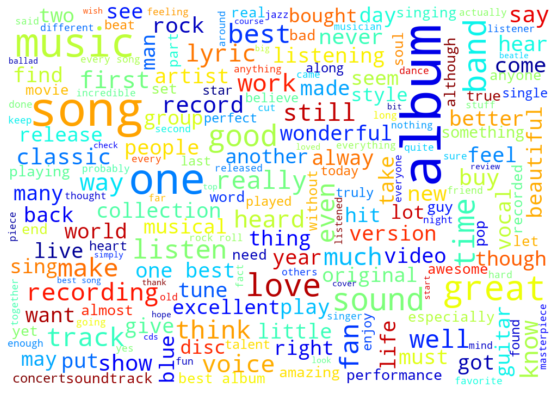

In [79]:
#Grafico World Cloud año 1999
wordcloud = WordCloud(width=1000, 
                     height=700, 
                     random_state=2,
                      colormap='jet',
                      background_color="white",
                     max_font_size=100).generate(all_words_lem)

plt.figure(figsize=(18, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

In [54]:
# funcion para contar las palabras lemantizadas
def word_count(string):
    words = string.lower().split()
    result = {}
    for word in words:
        if word not in result:
            result[word] = 0
        result[word] += 1

    return result

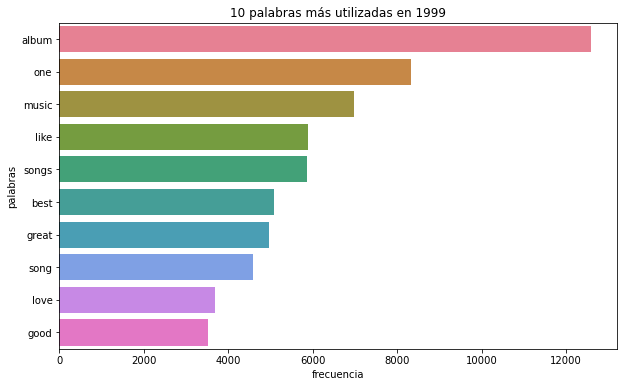

In [60]:
# Grafico de frecuencias de palabras en compras en 1999.-
words=word_count(all_words_lem)
words_freq = pd.DataFrame(words.items())
words_freq.columns=['palabras','frecuencia']
words_freq=words_freq.sort_values(by='frecuencia',ascending=False)

top10 = words_freq.iloc[0:10]
top10
plt.figure(figsize=(10,6))
sns.barplot("frecuencia","palabras", data=top10, palette="husl").set_title("10 palabras más utilizadas en 1999");

**Conclusión preliminar**

- Las 10 palabras más utilizadas por los compradores de CD y vinilos son: album, one,...., good.